# YOLO to ONNX

In [2]:
### init
# !pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt
import json
import base64
from io import BytesIO
import os
from datetime import datetime
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import torch
import torch.onnx
import onnx
import onnxruntime

In [3]:
# 推論用画像
paths = sorted(glob('mask_data/test_answer/images/*.png'))
print(len(paths))
# 画像の読み込み
imgs = []
for p in paths:
    img = Image.open(p)
    imgs.append(img)

300


## Prediction with PyTorch

In [4]:
# モデルサイズ確認
print('Size (MB):', os.path.getsize('yolov5_best.pt')/1e6)

Size (MB): 14.465205


In [5]:
# 学習済みモデルの読み込み
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5_best.pt', device='cpu')
print(model.training)

Using cache found in /Users/taichinakabeppu/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-4-28 torch 1.9.0 CPU

Fusing layers... 
[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.
Model summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


True


In [30]:
# 推論
start = datetime.now()
model.eval()
with torch.no_grad():
    # バッチ処理
    results = model(imgs)
end = datetime.now()
# 所要時間
print('Runtime =', end-start)

Runtime = 0:03:01.582600


In [31]:
# 結果格納
results_df = pd.DataFrame()
for p, n in zip(paths, range(len(results))):
    df_ = results.pandas().xyxy[n]
    p = p.replace('mask_data/test_answer/images/', '')
    df_.insert(0, 'file', p)
    results_df = pd.concat([results_df, df_])
results_df['xmin'] = results_df['xmin'].astype('int')
results_df['ymin'] = results_df['ymin'].astype('int')
results_df['xmax'] = results_df['xmax'].astype('int')
results_df['ymax'] = results_df['ymax'].astype('int')
results_df = results_df.drop('class', axis=1).rename(columns={'name': 'class'}).reset_index(drop=True)
results_df

,file,xmin,ymin,xmax,ymax,confidence,class
0,maksssksksss500.png,110,230,211,369,0.959684,with_mask
1,maksssksksss501.png,354,64,400,132,0.948252,with_mask
2,maksssksksss501.png,45,37,117,126,0.948185,with_mask
3,maksssksksss501.png,301,51,349,117,0.945372,with_mask
4,maksssksksss501.png,164,47,219,123,0.943369,with_mask
...,...,...,...,...,...,...,...
1422,maksssksksss799.png,86,239,131,284,0.914433,with_mask
1423,maksssksksss799.png,30,64,46,80,0.914345,with_mask
1424,maksssksksss799.png,317,248,333,265,0.897670,with_mask
1425,maksssksksss799.png,340,248,365,274,0.892757,with_mask


In [77]:
# %%capture
# !if [ ! -d fonts ]; then mkdir fonts & cd fonts & wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip & unzip NotoSansCJKjp-hinted.zip & cd .. ;fi

In [9]:
def visualize_results(results, image_path, threshold=0.4):
    image= Image.open(image_path)
    class_names = ['with_mask', 'mask_weared_incorrect', 'without_mask']
    cmap = plt.cm.get_cmap('hsv', len(class_names) + 1)

    prediction = results.numpy()
    boxes = []
    labels = []
    for pred in prediction:
        confidence = pred[4]
        if confidence >= threshold:
            boxes.append(pred[:4])
            labels.append(pred[-1].astype('int'))

    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype('fonts/NotoSansCJKjp-Bold.otf', 10)
    for box, label in zip(boxes, labels):
        color = cmap(label, bytes=True)
        # box
        draw.rectangle(box, outline=color)
        # label
        text = class_names[label]
        w, h = font.getsize(text)
        draw.rectangle([box[0], box[1], box[0]+w, box[1]+h], fill=color)
        draw.text((box[0], box[1]), text, font=font, fill='white')

    return image

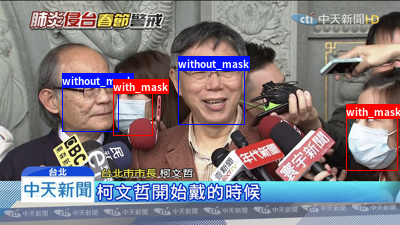

In [17]:
n = 2
visualize_results(results.xyxy[n], paths[n])

## Export ONNX

In [18]:
# 学習済みモデルの読み込み
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5_best.pt', device='cpu')

Using cache found in /Users/taichinakabeppu/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-4-28 torch 1.9.0 CPU

Fusing layers... 
Model summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [19]:
# ONNX 変換
def Export_ONNX(model):
    model.eval()
    dummy_input = torch.randn(1, 3, 640, 640, requires_grad=True)
    # Export the model
    torch.onnx.export(
        model,         # model being run 
        dummy_input,       # model input (or a tuple for multiple inputs) 
        "yolo.onnx",       # where to save the model
        verbose=False,
        export_params=True,  # store the trained parameter weights inside the model file 
        opset_version=11,    # the ONNX version to export the model to 
        do_constant_folding=True,  # whether to execute constant folding for optimization 
        input_names=['images'],   # the model's input names 
        output_names=['output'], # the model's output names 
        dynamic_axes={
            'images': {
                0: "batch_size",
                2: "height",
                3:"width"}, # shape(1, 3, 640, 640)
            'output': {0: 'batch'}
        }
        )
    # Checks
    model_onnx = onnx.load('yolo.onnx')  # load onnx model
    onnx.checker.check_model(model_onnx)

    # Metadata
    d = {'stride': int(model.stride), 'names': model.names}
    for k, v in d.items():
        meta = model_onnx.metadata_props.add()
        meta.key, meta.value = k, str(v)
    onnx.save(model_onnx, 'yolo.onnx')
    print(" ")
    print('Model has been converted to ONNX')

In [20]:
Export_ONNX(model)

/Users/taichinakabeppu/.cache/torch/hub/ultralytics_yolov5_master/models/yolo.py:62: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.onnx_dynamic or self.grid[i].shape[2:4] != x[i].shape[2:4]:


 
Model has been converted to ONNX


## Prediction with ONNX Model

In [21]:
# サイズ確認
print('Size (MB):', os.path.getsize('yolo.onnx')/1e6)

Size (MB): 28.142366


In [32]:
# ONNX モデル読み込み
onnx_model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolo.onnx', device='cpu')
print(onnx_model.training)

Using cache found in /Users/taichinakabeppu/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-4-28 torch 1.9.0 CPU

Loading yolo.onnx for ONNX Runtime inference...
Adding AutoShape... 


True


In [33]:
start = datetime.now()
onnx_model.eval()
with torch.no_grad():
    # バッチ処理
    results = onnx_model(imgs)
end = datetime.now()
print('Runtime =', end-start)

Runtime = 0:02:03.549016


In [34]:
onnx_results_df = pd.DataFrame()
for p, n in zip(paths, range(len(results))):
    df_ = results.pandas().xyxy[n]
    p = p.replace('mask_data/test_answer/images/', '')
    df_.insert(0, 'file', p)
    onnx_results_df = pd.concat([onnx_results_df, df_])
onnx_results_df['xmin'] = onnx_results_df['xmin'].astype('int')
onnx_results_df['ymin'] = onnx_results_df['ymin'].astype('int')
onnx_results_df['xmax'] = onnx_results_df['xmax'].astype('int')
onnx_results_df['ymax'] = onnx_results_df['ymax'].astype('int')
onnx_results_df = onnx_results_df.drop('class', axis=1).rename(columns={'name': 'class'}).reset_index(drop=True)
onnx_results_df

,file,xmin,ymin,xmax,ymax,confidence,class
0,maksssksksss500.png,110,230,211,369,0.959685,with_mask
1,maksssksksss501.png,354,64,400,132,0.948251,with_mask
2,maksssksksss501.png,45,37,117,126,0.948185,with_mask
3,maksssksksss501.png,301,51,349,117,0.945373,with_mask
4,maksssksksss501.png,164,47,219,123,0.943369,with_mask
...,...,...,...,...,...,...,...
1422,maksssksksss799.png,86,239,131,284,0.914434,with_mask
1423,maksssksksss799.png,30,64,46,80,0.914345,with_mask
1424,maksssksksss799.png,317,248,333,265,0.897670,with_mask
1425,maksssksksss799.png,340,248,365,274,0.892757,with_mask


In [35]:
results_df

,file,xmin,ymin,xmax,ymax,confidence,class
0,maksssksksss500.png,110,230,211,369,0.959684,with_mask
1,maksssksksss501.png,354,64,400,132,0.948252,with_mask
2,maksssksksss501.png,45,37,117,126,0.948185,with_mask
3,maksssksksss501.png,301,51,349,117,0.945372,with_mask
4,maksssksksss501.png,164,47,219,123,0.943369,with_mask
...,...,...,...,...,...,...,...
1422,maksssksksss799.png,86,239,131,284,0.914433,with_mask
1423,maksssksksss799.png,30,64,46,80,0.914345,with_mask
1424,maksssksksss799.png,317,248,333,265,0.897670,with_mask
1425,maksssksksss799.png,340,248,365,274,0.892757,with_mask


In [36]:
np.unique(onnx_results_df['class'], return_counts=True)

(array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype=object),
 array([  27, 1175,  225]))

In [37]:
np.unique(results_df['class'], return_counts=True)

(array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype=object),
 array([  27, 1175,  225]))

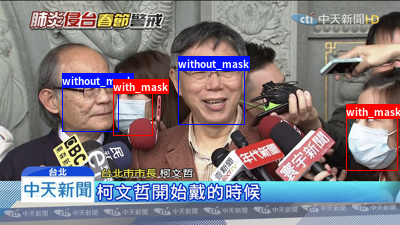

In [24]:
n = 2
visualize_results(results.xyxy[n], paths[n])

## ONNX Runtime

In [ ]:
import onnxruntime

In [203]:
img = Image.open(paths[0]).convert('RGB')
img = img.resize([640, 640])
img_data = np.array(img, dtype='float32')
img_data /= 255
img_data = np.transpose(img_data, [2, 0, 1])
img_data = np.expand_dims(img_data, 0)

In [204]:
session = onnxruntime.InferenceSession('yolo.onnx')

In [205]:
out = session.run(None, {'images': img_data})

In [206]:
out[0][0][0]

array([     4.2146,      4.5375,      10.314,      15.986,  8.6725e-06,     0.70093,    0.045178,     0.29705], dtype=float32)

In [213]:
out[0][0]

array([[     4.2146,      4.5375,      10.314, ...,     0.70093,    0.045178,     0.29705],
       [     12.776,      5.6764,      24.198, ...,     0.54898,    0.055967,     0.36242],
       [     18.681,      4.3331,      33.507, ...,     0.56105,    0.037742,     0.44891],
       ...,
       [     570.95,      606.44,      347.01, ...,     0.29749,     0.24229,     0.22642],
       [     586.69,      603.72,      209.62, ...,     0.38223,     0.17725,     0.24477],
       [     607.63,      607.44,      283.05, ...,     0.31305,     0.22977,     0.26856]], dtype=float32)

In [191]:
df = pd.DataFrame(out[0][0])
df = df.rename(columns={0:'xmin', 1:'ymin', 2:'xmax', 3:'ymax', 4:'confidence', 5:'with_mask', 6:'mask_weared_incorrect', 7:'without_mask'})
df

,xmin,ymin,xmax,ymax,confidence,with_mask,mask_weared_incorrect,without_mask
0,4.214570,4.537497,10.313617,15.985667,8.672476e-06,0.700935,0.045178,0.297051
1,12.776090,5.676386,24.197996,15.200418,2.652407e-06,0.548981,0.055967,0.362423
2,18.680874,4.333120,33.507317,12.852788,2.145767e-06,0.561048,0.037742,0.448910
3,26.508099,4.274238,35.192181,12.477221,9.238720e-07,0.632332,0.032041,0.417051
4,33.960983,4.160562,35.272701,11.803977,5.662441e-07,0.651438,0.028722,0.364463
...,...,...,...,...,...,...,...,...
25195,493.527527,604.938293,866.446777,790.824097,7.003546e-06,0.018933,0.558842,0.431098
25196,523.272339,603.406799,581.229065,550.291077,3.099442e-06,0.162965,0.322442,0.236716
25197,570.945251,606.444519,347.007294,260.588562,1.093745e-05,0.297493,0.242286,0.226423
25198,586.689819,603.715576,209.623520,170.480194,1.293421e-05,0.382226,0.177253,0.244768


In [253]:
# Non-Maximun Suppression が必要になる

---

In [55]:
# !unzip -q test.zip

In [28]:
test_paths = sorted(glob('mask_data/test/*.png'))
len(test_paths)

10

In [29]:
test_paths[:3]

['mask_data/test/maksssksksss500.png',
 'mask_data/test/maksssksksss501.png',
 'mask_data/test/maksssksksss502.png']

In [30]:
files = []
for path in test_paths:
    img = Image.open(path).convert('RGB')
    buffered = BytesIO()
    img.save(buffered, format='JPEG')
    img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
    p = path.replace('test/images/', '')
    file = {
        'file': p,
        'img': img_str
    }
    files.append(file)
# json_images = json.dumps(file)

In [33]:
type(img_str)

str

In [31]:
with open('mask_data/test.json', 'w') as f:
    json.dump(files, f, indent=4)

---

In [34]:
with open('test.json') as f:
    test_dict_data = json.load(f)

In [35]:
len(test_dict_data)

300

In [36]:
file_names, images = [], []
for data in test_dict_data:
    file_names.append(data['file'])
    image_str = data['img']
    image_bytes = base64.b64decode(image_str.encode('utf-8'))
    image_bytesio = BytesIO(image_bytes)
    image = Image.open(image_bytesio)
    images.append(image)

In [37]:
len(file_names), len(images)

(300, 300)

In [38]:
file_names[:2]

['maksssksksss500.png', 'maksssksksss501.png']

In [7]:
# ONNX モデル読み込み
onnx_model = torch.hub.load(
    'ultralytics/yolov5',
    'custom',
    path='yolo.onnx',
    device='cpu')

# 推論
start = datetime.now()
onnx_model.eval()
with torch.no_grad():
    results = onnx_model(images)
end = datetime.now()
print('Runtime =', end-start)

# 結果格納
results_df = pd.DataFrame()
for p, n in zip(file_names, range(len(results))):
    df_ = results.pandas().xyxy[n]
    # p = p.replace('mask_data/test_answer/images/', '')
    df_.insert(0, 'file', p)
    results_df = pd.concat([results_df, df_])
results_df['xmin'] = results_df['xmin'].astype('int')
results_df['ymin'] = results_df['ymin'].astype('int')
results_df['xmax'] = results_df['xmax'].astype('int')
results_df['ymax'] = results_df['ymax'].astype('int')
results_df = results_df.drop('class', axis=1).rename(columns={'name': 'class'}).reset_index(drop=True)
results_df

Using cache found in /Users/taichinakabeppu/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-4-28 torch 1.9.0 CPU

Loading yolo.onnx for ONNX Runtime inference...
Adding AutoShape... 


Runtime = 0:01:14.502966


,file,xmin,ymin,xmax,ymax,confidence,class
0,maksssksksss500.png,111,231,212,370,0.958664,with_mask
1,maksssksksss501.png,44,37,117,126,0.951905,with_mask
2,maksssksksss501.png,160,47,220,122,0.950687,with_mask
3,maksssksksss501.png,353,64,400,132,0.949953,with_mask
4,maksssksksss501.png,302,52,349,117,0.943344,with_mask
...,...,...,...,...,...,...,...
1297,maksssksksss799.png,44,41,64,65,0.904429,with_mask
1298,maksssksksss799.png,85,238,133,283,0.899709,with_mask
1299,maksssksksss799.png,317,248,332,264,0.875682,with_mask
1300,maksssksksss799.png,304,211,324,229,0.867625,with_mask


In [43]:
results_df.head(10)

,file,xmin,ymin,xmax,ymax,confidence,class
0,maksssksksss500.png,111,231,212,370,0.958664,with_mask
1,maksssksksss501.png,44,37,117,126,0.951905,with_mask
2,maksssksksss501.png,160,47,220,122,0.950687,with_mask
3,maksssksksss501.png,353,64,400,132,0.949953,with_mask
4,maksssksksss501.png,302,52,349,117,0.943344,with_mask
5,maksssksksss501.png,0,44,42,126,0.941737,with_mask
6,maksssksksss501.png,232,38,297,108,0.926159,with_mask
7,maksssksksss502.png,177,57,244,123,0.961261,without_mask
8,maksssksksss502.png,59,73,118,130,0.951826,without_mask
9,maksssksksss502.png,346,103,398,169,0.948219,with_mask


In [34]:
output = []
for file_name in file_names:
    out = {}
    out['file'] = file_name
    out['prediction'] = []
    df = results_df[results_df['file']==file_name]
    for index, row in df.iterrows():
        pred = {}
        pred['class'] = row['class']
        pred['xmin'] = row['xmin']
        pred['ymin'] = row['ymin']
        pred['xmax'] = row['xmax']
        pred['ymax'] = row['ymax']
        pred['confidence'] = row['confidence']
        out['prediction'].append(pred)
    output.append(out)

In [38]:
output[0]

{'file': 'maksssksksss500.png',
 'prediction': [{'class': 'with_mask',
   'xmin': 111,
   'ymin': 231,
   'xmax': 212,
   'ymax': 370,
   'confidence': 0.9586641788482666}]}

In [42]:
len(output[1]['prediction'])

6

In [44]:
# 書き出し
with open('output.json', 'w') as fp:
    json.dump(output, fp, ensure_ascii=False)

---

In [1]:
### init ###
import json
import base64
from io import BytesIO
import os
from datetime import datetime
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import torch
import torch.onnx
import onnx
import onnxruntime

In [2]:
def create_data(INPUT_FILE_PATH):

    with open(INPUT_FILE_PATH) as f:
        test_dict_data = json.load(f)

    file_names, images = [], []
    for data in test_dict_data:
        file_names.append(data['file'])
        image_str = data['img']
        image_bytes = base64.b64decode(image_str.encode('utf-8'))
        image_bytesio = BytesIO(image_bytes)
        image = Image.open(image_bytesio)
        images.append(image)

    return file_names, images

In [3]:
def load_model(MODEL_FILE_PATH):
    model = torch.hub.load(
        'ultralytics/yolov5',
        'custom',
        path=MODEL_FILE_PATH,
        device='cpu')
    model.eval()
    return model

In [4]:
def predict(model, images):

    start = datetime.now()
    with torch.no_grad():
        results = model(images)
    end = datetime.now()
    print('Runtime =', end-start)

    return results

In [5]:
def create_output(file_names, results, OUTPUT_FILE_PATH):
    results_df = pd.DataFrame()
    for p, n in zip(file_names, range(len(results))):
        df_ = results.pandas().xyxy[n]
        # p = p.replace('mask_data/test_answer/images/', '')
        df_.insert(0, 'file', p)
        results_df = pd.concat([results_df, df_])
    results_df['xmin'] = results_df['xmin'].astype('int')
    results_df['ymin'] = results_df['ymin'].astype('int')
    results_df['xmax'] = results_df['xmax'].astype('int')
    results_df['ymax'] = results_df['ymax'].astype('int')
    results_df = results_df.drop('class', axis=1).rename(columns={'name': 'class'}).reset_index(drop=True)

    output = []
    for file_name in file_names:
        out = {}
        out['file'] = file_name
        out['prediction'] = []
        df = results_df[results_df['file']==file_name]
        for index, row in df.iterrows():
            pred = {}
            pred['class'] = row['class']
            pred['xmin'] = row['xmin']
            pred['ymin'] = row['ymin']
            pred['xmax'] = row['xmax']
            pred['ymax'] = row['ymax']
            pred['confidence'] = row['confidence']
            out['prediction'].append(pred)
        output.append(out)

    return output

In [6]:
INPUT_FILE_PATH = 'test.json'
MODEL_FILE_PATH = 'yolo.onnx'
OUTPUT_FILE_PATH = 'output.json'

In [7]:
def main():
    print('Start processing')
    file_names, images = create_data(INPUT_FILE_PATH)
    model = load_model(MODEL_FILE_PATH)
    results = predict(model, images)
    output = create_output(file_names, results, OUTPUT_FILE_PATH)
    # 書き出し
    with open(OUTPUT_FILE_PATH, 'w') as fp:
        json.dump(output, fp, ensure_ascii=False)
    print(' ')
    print('File export is complete')

In [8]:
if __name__ == '__main__':
    main()

Start processing


Using cache found in /Users/taichinakabeppu/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-4-28 torch 1.9.0 CPU

Loading yolo.onnx for ONNX Runtime inference...
Adding AutoShape... 


Runtime = 0:01:56.070969
 
File export is complete


In [9]:
with open(OUTPUT_FILE_PATH) as f:
    data = json.load(f)

In [10]:
data[0]

{'file': 'maksssksksss500.png',
 'prediction': [{'class': 'with_mask',
   'xmin': 111,
   'ymin': 231,
   'xmax': 212,
   'ymax': 370,
   'confidence': 0.9586641788482666}]}